In [1]:
from ipstartup import *
croot = "c:" if os.name=="nt" else "/mnt/c"
droot = "d:" if os.name=="nt" else "/mnt/d"
os.chdir(f"{droot}/data1")
sys.path.append(f"{croot}/Users/simon/OneDrive/Documents/py/live/slab/src")
############################################################################
from transformers import pipeline
import numpy as np
import pandas as pd
from model.utils import *

# feature_extraction => sents,bs=1,tokens,features=768
model = "nbroad/ESG-BERT"
pipe = pipeline('feature-extraction', model=model)

[defaultlog:22:INFO]:logging started from /mnt/c/users/simon/onedrive/documents/py/live/pyutils/defaultlog.py (time=Jul-09 09:40 MainProcess)


Some weights of the model checkpoint at nbroad/ESG-BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
sents = pd.read_csv("Clean_sentences.csv").Sentences.tolist()
sents = [s.replace("_"," ") for s in sents]
sents = Document(sents, pipe)
kpis = pd.read_excel("KPI levels list.xlsx")["Level 3 KPI"].tolist()
kpis = Document(kpis, pipe)

[cellevents:43:INFO]:starting (time=Jul-09 09:41 MainProcess)


time: 637 ms


In [3]:
# get features
sents.get_feats()
kpis.get_feats()

[cellevents:43:INFO]:starting (time=Jul-09 09:41 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

time: 22.6 s


In [52]:
sentdf = sents.compare_sents(kpis)
sentdf.sample(3)

[cellevents:43:INFO]:starting (time=Jul-09 10:20 MainProcess)


,kpi,score
sent,,
our benchmark to achieve greater energy efficiency and establish our carbon emission reduction targets is the home 75 average hers scores reflect energy-efficient kb homes energy rating system (hers) index.,"Amount of reductions in [renewable, non-renewa...",0.862102
"our two shorter-term company targets act as stepping stones to our long-term ambitions: e our science-based target-aims to reduce our scope 1 and 2 emissions by 80% between 2015 and 2025, and the absolute scope 5 emissions from the use of our sold products by 25% during the same time period.","Amount of reductions in [renewable,non-renewab...",0.648771
"the initiative also demands footprint and yn sd th decentralises farming by ensuring every urban farm is within 5 km of the local communities, reducing the food miles higher yield distance from farm to plate and eventually lowering consumers carbon footprint.","Amount of reductions in [renewable,non-renewab...",0.277055


time: 79.5 ms


In [4]:
# inspect ngram embedding dataframe on a sentence
# note ngrams are within the context of the sentence. "energy" has different embeddings in different sentences.
i = np.random.randint(len(sents.sents))
ngram, kpi, score, ngramdf1 = sents.compare_ngrams(i, kpis, 5)
sent = pipe.tokenizer.decode(pipe.tokenizer.encode(sents.sents[i]))
print(i, sent)
ngramdf1[:10]

[cellevents:43:INFO]:starting (time=Jul-09 09:41 MainProcess)


106 [CLS] we have built over 150, 000 energy star certified homes since 2000, cumulatively reducing ghg emissions by an estimated 5. 6 billion pounds ( 2. 5 million metric tons ), the equivalent of removing nearly 557, 000 cars from the road for one year, and helping homeowners to save a cumulative estimated $ 800 million on utility bills. [SEP]


,best,score
ngram,,


time: 106 ms


In [16]:
# ngrams for all sentences
res = []
for i, sent in enumerate(tqdm(sents.sents)):
    ngram, kpi, score, _ = sents.compare_ngrams(i, kpis)
    res.append([sent, ngram, kpi, score])
ngramdf = pd.DataFrame(res, columns=["sent", "ngram", "kpi", "score"])
ngramdf = ngramdf.set_index("sent")

[cellevents:43:INFO]:starting (time=Jul-09 09:48 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

time: 22.4 s


[cellevents:43:INFO]:starting (time=Jul-09 09:49 MainProcess)


<AxesSubplot:>

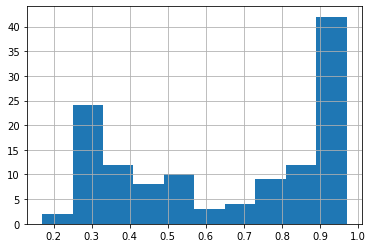

time: 339 ms


In [17]:
ngramdf.score.hist()

In [ ]:
# merge sent and ngram
out = ngramdf.join(sentdf, rsuffix="_sent")[["ngram", "kpi", "score", "kpi_sent", "score_sent"]]


In [55]:
# merge sent and ngram
out = ngramdf.join(sentdf, rsuffix="_sent")[["ngram", "kpi", "score", "kpi_sent", "score_sent"]]

# add labels
labeldf = pd.read_excel("Sentences_KPI_mapping.xlsx")
labeldf.columns = ["sent", "true1", "true3"]
labeldf = labeldf.set_index("sent")
out = out.join(labeldf)
out["correct"] = out.kpi==out.true3
out["correct_sent"] = out.kpi_sent==out.true3

# merge original
# ngramdf1 = pd.read_excel("output/sent_ngram.xlsx").set_index("sent")
# out = out.join(ngramdf1, lsuffix="_kpi3")[["ngram", "kpi_kpi3", "true3", "correct", "kpi", "kpi_sent", "score_kpi3", "score", "score_sent"]]
# out.to_excel("output/sent_ngram3.xlsx")
out

[cellevents:43:INFO]:starting (time=Jul-09 10:23 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent,true1,true3,correct,correct_sent
sent,,,,,,,,,
170 business leaders call on eu decision-makers to support a greenhouse gas (ghg) emissions reduction target of at least 55% by 2030.,-,"Amount of [solar, wind, hydropower, renewable,...",0.257927,"Amount of [solar, wind, hydropower, renewable,...",0.225446,NaN,NaN,False,False
"2020 index 2015 = 100 in europe, electrolux continued to improve its energy efficiency across three product categories in 2020. the energy index is set at 100% for 2016.",energy efficiency across,"Amount of reductions in [electricity,heating,c...",0.839030,"Amount of reductions in [electricity,heating,c...",0.809627,NaN,NaN,False,False
"340 locomotives hydroelectric power, accounted for approximately 14% of mitsuis total power generating capacity of locomotive leasing busirress europe 11.1gw, and we are aiming to increase the share held by renewable energy to 30% by 2030. freight wagon transportation business brazil operating a railway network of approx.",held by renewable energy,"Amount of [solar, wind, hydropower, renewable,...",0.917723,"Amount of [solar, wind, hydropower, renewable,...",0.884295,NaN,NaN,False,False
"45 progress on our climate targets our science-based climate target by the end of 2020, we reduced our absolute scope | and 2 greenhouse gas emissions by 70% compared to 2015-toward our 80% reduction target by 2025 and our 100% reduction by 2030. read more about our scope 1 & 2 emissions in our promise be climate neutral and drive clean and resource-efficient operations.",and resource -,"Amount of [solar, wind, hydropower, renewable,...",0.399272,"Amount of [solar, wind, hydropower, renewable,...",0.307314,NaN,NaN,False,False
62.2% use of electricity from renewable sources achieved and total energy consumption from fossil fuel sources reduced by 86% compared to 2017.,% use of electricity from renewable sources ac...,"Amount of [electricity, heating, cooling, stea...",0.967180,"Amount of [electricity, heating, cooling, stea...",0.964406,"Consumption of energy in owned operations, ass...",Amount of electricity consumption within the o...,False,False
...,...,...,...,...,...,...,...,...,...
we expect renewable energy usage rate to reach approximately 7% in fiscal 2020.,usage,"Amount of [electricity, heating, cooling, stea...",0.932550,"Amount of [electricity, heating, cooling, stea...",0.916122,"Consumption of energy in owned operations, ass...",Amount of energy consumption within the organi...,False,False
"we have built over 150,000 energy star certified homes since 2000, cumulatively reducing ghg emissions by an estimated 5.6 billion pounds (2.5 million metric tons), the equivalent of removing nearly 557,000 cars from the road for one year, and helping homeowners to save a cumulative estimated $800 million on utility bills.",on,"Amount of [solar, wind, hydropower, renewable,...",0.494552,"Amount of [solar, wind, hydropower, renewable,...",0.416669,NaN,NaN,False,False
what we achieved electrolux improved its energy efficiency per product by 11.5% compared to 2015. the energy management program has contributed to over sek 700m annually in reduced energy costs.,energy efficiency per product by,"Amount of reductions in [electricity,heating,c...",0.938416,"Amount of reductions in [electricity,heating,c...",0.923484,NaN,NaN,False,False


time: 83.1 ms
